#**Ranking BM-25**
##1. Preparing the dataset
* Docs dataset
* Queries dataset
* Qrels dataset

In [1]:

import re

from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [2]:
import csv
import pandas as pd
import sys

csv.field_size_limit(sys.maxsize)

# Define the paths
qrels_file_path = '/content/drive/MyDrive/Advanced Information Retrieval - Trabajo/CLEAN DATASETS/qrels.csv'
queries_file_path = '/content/drive/MyDrive/Advanced Information Retrieval - Trabajo/CLEAN DATASETS/queries.csv'
docs_file_path = '/content/drive/MyDrive/Advanced Information Retrieval - Trabajo/CLEAN DATASETS/docs.csv'
# Create new dataframes
queries_df= pd.read_csv(queries_file_path)
queries_df.set_index('id_query', inplace=True)

docs_df = pd.read_csv(docs_file_path)
docs_df.set_index('id_document', inplace=True)
docs_df = docs_df.drop('_id', axis=1)

qrels = {}

# Load the qrels data in the qrels dictionary
with open(qrels_file_path, newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        key = int(row['Key'])
        if row['Values'] and row['Values'].strip('[]'):
          values = [int(value) for value in row['Values'].strip('[]').split(',')]
        else:
          values = []
        qrels[key] = values

In [3]:
#tokenizing
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Create a Porter Stemmer instance
porter_stemmer = PorterStemmer()

def clean_text(text):
    # Eliminate mentions, hashtags, RTs and URLs
    text = re.sub(r'(@\w+)|(#\w+)|RT|http\S+', '', text)
    # Eliminate special characters and numbers
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Text to lower case
    text = text.lower().strip()
    # Tokenize and apply Porter Stemmer
    tokens = text.split()
    stemmed_tokens = [porter_stemmer.stem(word) for word in tokens]
    # Remove stop words
    text = [word for word in text.split() if word not in stop_words]
    return text

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

docs_df['clean'] = docs_df['docs'].apply(clean_text)
queries_df['clean'] = queries_df['query'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
!pip install rank_bm25
from rank_bm25 import BM25Okapi
# Extract processed tokens for BM25
tokenized_texts =docs_df['clean']
#initialize model
bm25 = BM25Okapi(tokenized_texts)

In [5]:
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, ndcg_score
!pip install rank_bm25
from rank_bm25 import BM25Okapi


import warnings
warnings.filterwarnings('ignore')

def validate_F1k(relevant_docs,ranked_docs, k: int = 5) -> float:
  true_positive = 0 #precision relevants in my group
  false_positive = 0 #precision not relevants in my group
  false_negative = 0 #recall relevants not in my group
  i=0
  for doc in ranked_docs:
        if(doc in relevant_docs):
          if(i< k):
            true_positive = true_positive + 1
          else:
            false_negative = false_negative + 1
        else:
          if(i<k):
            false_positive = false_positive + 1
        i= i +1

  #if we dont have any relevant documents f1 = 0
  if (true_positive == 0):
      precision = 0
      recall = 0
      return 0
  else:
    #if we have relevants documents calculate the formula
    precision = true_positive/(true_positive + false_positive)
    recall = true_positive/(true_positive + false_negative)
    f1 = (2 * precision * recall)/ (precision + recall)
    return  f1

def validate_ndcg(relevant_docs,ranked_docs, k: int = 5):
  i=1
  dcg_slice = np.array([])
  rel_docs = 0 #this is a count for idcg
  for doc in ranked_docs:
    result = 0
    if(doc in relevant_docs):
      rel = 1 #dcg
      rel_docs = rel_docs + 1 #idcg
    else:
      rel = 0 #dcg
    result = rel/np.log2(i+1)
    i=i+1
    dcg_slice = np.append(dcg_slice, result)


  dcg_k =0
  idcg_k=0
  for q in range(k):
    dcg_k = dcg_k + dcg_slice[q]
    if(q < rel_docs):
      idcg_k = idcg_k + 1/np.log2((q+1)+1) #we add 1 to the formula because q goes from 0 to k-1
  #calculating n_dcg
  if(dcg_k == 0):
    num = 0
  else :
    num = dcg_k/idcg_k

  return num
ranked_docs_bm25 = []
f1_total = []
ndcg_total = []
for i, row in queries_df.iterrows():
  query = row['clean']
  doc_scores = bm25.get_top_n(query, tokenized_texts, n = 25)

  # Filtwe the dataframe
  resultados = docs_df[docs_df['clean'].apply(lambda x: any(x == var for var in doc_scores))]
  # Organize the values and search the relevant values in qrels
  resultados['indice_coincidente'] = resultados['clean'].apply(lambda x: next((i for i, var in enumerate(doc_scores) if x == var), -1))
  ranked_docs = resultados.sort_values(by='indice_coincidente').drop(columns=['indice_coincidente'])
  ranked_docs = list(ranked_docs.index)
  relevant_docs = qrels.get(i, [])
  ranked_docs_bm25.append(ranked_docs)
  # Calculate f1
  f1 = validate_F1k(relevant_docs, ranked_docs, 25)
  # Calculate NDCG
  ndcg = validate_ndcg(relevant_docs,ranked_docs,25)
  f1_total.append(f1)
  ndcg_total.append(ndcg)
  if i == 500: #only 500 for not overloading the google collab
    break


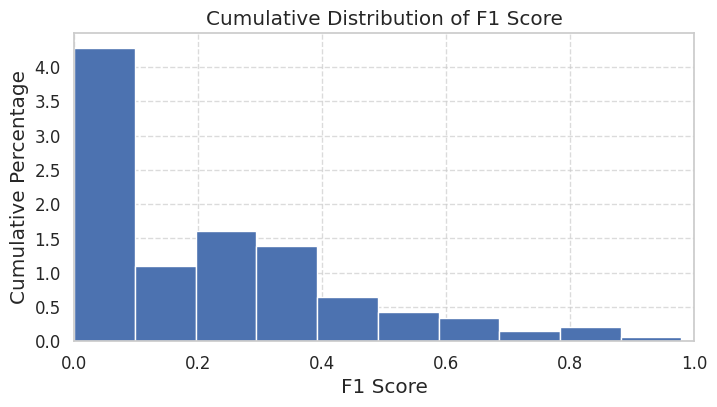

In [11]:

import matplotlib.pyplot as plt
import seaborn as sns
# Set Seaborn style
sns.set(style='whitegrid', font_scale=1.2)

# Create a cumulative histogram of F1 Score values
plt.figure(figsize=(8,4))
plt.hist(f1_total, density= True)


# Set x and y-axis limits
plt.xlim(0, 1)  # Set x-axis limits from 0 to 1

# Set labels and title
plt.xlabel('F1 Score')
plt.ylabel('Cumulative Percentage')
plt.title('Cumulative Distribution of F1 Score')

# Add a grid
plt.grid(True, linestyle='--', alpha=0.7)

# Customize tick parameters
plt.tick_params(axis='both', which='major', labelsize=12)

# Show the plot
plt.show()

In [7]:
import statistics
statistics.mean(f1_total)

0.2226582069452706

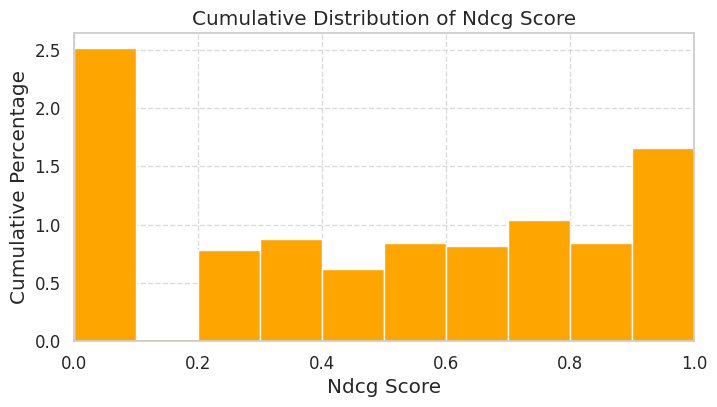

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
# Set Seaborn style
sns.set(style='whitegrid', font_scale=1.2)

# Create a cumulative histogram of Ndcg Score values
plt.figure(figsize=(8,4))
# Crear un histograma acumulado de los valores de F1 Score
plt.hist(ndcg_total, density= True, color ='orange')


# Set x and y-axis limits
plt.xlim(0, 1)  # Set x-axis limits from 0 to 1


# Set labels and title
plt.xlabel('Ndcg Score')
plt.ylabel('Cumulative Percentage')
plt.title('Cumulative Distribution of Ndcg Score')

# Add a grid
plt.grid(True, linestyle='--', alpha=0.7)

# Customize tick parameters
plt.tick_params(axis='both', which='major', labelsize=12)

# Show the plot
plt.show()

In [9]:
import statistics
statistics.mean(ndcg_total)

0.48680820083958715

#BBERT

In [13]:
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer
import scipy.spatial
import pandas as pd


queries = [' '.join(query) for query in queries_df['clean'][:501]]

# BERT Embeddings
embedder = SentenceTransformer('bert-base-nli-mean-tokens')
query_embeddings = embedder.encode(queries)
ndcg_total_bbert = []
# Find the closest based on cosine similarity
closest_n = 10
for i, (query, query_embedding) in enumerate(zip(queries, query_embeddings)):
    #only for the docs in each query
    docs_corpus = [docs_df['clean'][indice] for indice in ranked_docs_bm25[i]]
    corpus = [' '.join(doc) for doc in docs_corpus]
    corpus_embeddings = embedder.encode(corpus)

    distances = scipy.spatial.distance.cdist([query_embedding], corpus_embeddings, "cosine")[0]

    results_bbert = zip(range(len(distances)), distances)
    results_bbert = sorted(results_bbert, key=lambda x: x[1])
    #Calculate which docs are the ranked by bbert
    results_bert_docs = []
    for tupla in results_bbert[:10]:
        indice_tupla, _ = tupla
        results_bert_docs.append(ranked_docs_bm25[i][indice_tupla])

    relevant_docs = qrels.get(i, [])
    # Calculate NDCG

    ndcg = validate_ndcg(relevant_docs,results_bert_docs,10) # Puedes ajustar k según tus necesidades
    ndcg_total_bbert.append(ndcg)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Set Seaborn style
sns.set(style='whitegrid', font_scale=1.2)

# Create a cumulative histogram of Ndcg scores
plt.figure(figsize=(8,4))
plt.hist(ndcg_total_bbert, density= True, color ='green')


# Set x and y-axis limits
plt.xlim(0, 1)  # Set x-axis limits from 0 to 1


# Set labels and title
plt.xlabel('Ndcg Score')
plt.ylabel('Cumulative Percentage')
plt.title('Cumulative Distribution of Ndcg Score')

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Customize tick parameters
plt.tick_params(axis='both', which='major', labelsize=12)

# Show the plot
plt.show()

In [14]:
import statistics
statistics.mean(ndcg_total_bbert)

0.3999457536573774

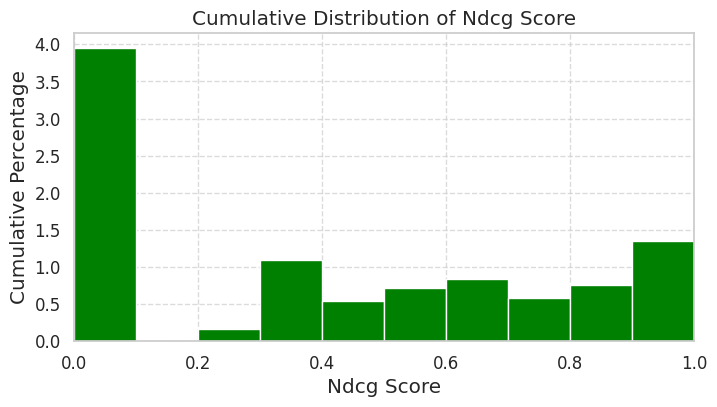

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
# Set Seaborn style for improved aesthetics
sns.set(style='whitegrid', font_scale=1.2)

# Create a cumulative histogram of F1 Score values with enhanced styling
plt.figure(figsize=(8,4))
# Crear un histograma acumulado de los valores de F1 Score
plt.hist(ndcg_total_bbert, density= True, color ='green')


# Set x and y-axis limits
plt.xlim(0, 1)  # Set x-axis limits from 0 to 1
#plt.ylim(0, 100)  # Set y-axis limits from 0 to 100

# Set labels and title
plt.xlabel('Ndcg Score')
plt.ylabel('Cumulative Percentage')
plt.title('Cumulative Distribution of Ndcg Score')

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Customize tick parameters
plt.tick_params(axis='both', which='major', labelsize=12)

# Show the plot
plt.show()